In [ ]:
import pandas as pd
import numpy as np
import torch


## 1

### Load data

In [3]:
# Read infection data
x = np.loadtxt('./data/RealEpidemics/infected_numbers_H1N1.csv', delimiter=',')

# Read adjacency matrix (flight data)
A = np.loadtxt('./data/RealEpidemics/Flights_adj.csv', delimiter=',')

# Read populations
populations = np.loadtxt('./data/RealEpidemics/populations.csv', delimiter=',')

# Read country names (assuming second column contains names)
countries_df = pd.read_csv('./data/RealEpidemics/Country_Population_final.csv')
countries = countries_df.iloc[:, 1].astype(str).values  # Convert to string array

# Extract x_values (from second column onward)
x_values = x[:, 1:]

In [4]:
print(x_values.shape)
print(A.shape)
print(populations.shape)
print(countries.shape)

(51, 234)
(234, 234)
(234,)
(234,)


### Deleting 0 infected countries

In [5]:
no_infected = np.where(np.mean(x_values, axis=0) == 0)[0]
# Remove those columns/entries from all relevant data
populations = np.delete(populations, no_infected, axis=0)
x_values = np.delete(x_values, no_infected, axis=1)
A = np.delete(A, no_infected, axis=0)
A = np.delete(A, no_infected, axis=1)
countries = np.delete(countries, no_infected, axis=0)

In [6]:
print(x_values.shape)
print(A.shape)
print(countries.shape)
print(populations.shape)

(51, 130)
(130, 130)
(130,)
(130,)


### Interp points

In [7]:
from scipy.interpolate import interp1d

# Reattach the time column to x_values
x = np.column_stack((x[:, 0], x_values))

# Extract timepoints
timepoints = x[:, 0].astype(int)
fully_timepoints = np.arange(0, int(x[-1, 0]) + 1)

# Find missing timepoints
missing_timepoints = np.setdiff1d(fully_timepoints, timepoints)

# Interpolate missing values
interp_points = np.zeros((len(missing_timepoints), x_values.shape[1]))

for ii in range(x_values.shape[1]):
    f = interp1d(timepoints, x_values[:, ii], kind='linear', fill_value="extrapolate")
    interp_points[:, ii] = np.ceil(f(missing_timepoints))

# Combine interpolated points with time column
interp_points = np.column_stack((missing_timepoints, interp_points))

# Concatenate original and interpolated data
x = np.vstack((x, interp_points))

# Sort by time (column 0)
x = x[np.argsort(x[:, 0])]

In [8]:
x.shape

(74, 131)

In [9]:
x_values = x[:, 1:]
print(x_values.shape)

(74, 130)


### Normalize Adj


In [10]:
# Remove self-loops in A (zero the diagonal)
Aij = A - np.diag(np.diag(A))
Aij_act = Aij * 8.91e6 / np.sum(populations)

### Delete less than 100 infected

In [11]:
infected = []
for i in range(x_values.shape[1]):
    start_time = np.argmax(x_values[:, i] > 0)  # First index where x_values > 0
    infected.append(x_values[start_time:, i])

data = []
Ind = []
j = 0
Period = 45

for i, inf in enumerate(infected):
    if len(inf) >= Period and inf[Period - 1] >= 100:
        data.append(inf[:Period])
        Ind.append(i)
        j += 1
data = np.column_stack(data)
print(data.shape)

(45, 21)


In [14]:
all_indices = np.arange(len(Aij_act))
cut_off = np.setdiff1d(all_indices, Ind)

In [15]:
# Remove unwanted rows/columns using boolean indexing
mask = np.ones(len(A), dtype=bool)
mask[cut_off] = False

populations = populations[mask]
countries = countries[mask]
A = A[mask][:, mask]
Aij_act = Aij_act[mask][:, mask]

In [16]:
country_dict = dict(zip(countries, range(len(countries))))
country_dict

{'Canada': 0,
 'United Kingdom': 1,
 'Spain': 2,
 'Greece': 3,
 'Guatemala': 4,
 'Mexico': 5,
 'Panama': 6,
 'Costa Rica': 7,
 'El Salvador': 8,
 'Japan': 9,
 'Philippines': 10,
 'Argentina': 11,
 'Brazil': 12,
 'Chile': 13,
 'Ecuador': 14,
 'Peru': 15,
 'Thailand': 16,
 'Malaysia': 17,
 'Australia': 18,
 'China': 19,
 'United States': 20}

### Plotting countries

In [17]:
import matplotlib.pyplot as plt

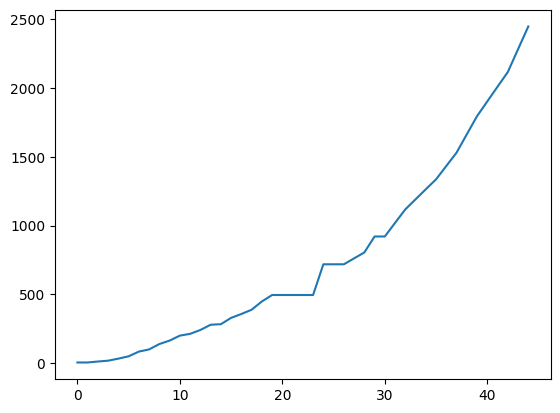

In [29]:
plt.plot(data[:, country_dict['Canada']])

### Building edge_index and edge_attrs

In [19]:
row, col = np.nonzero(Aij_act)
edge_index = torch.tensor(np.array([row, col]), dtype=torch.long)

edge_index

tensor([[ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  1,  1,
          1,  1,  1,  1,  1,  1,  1,  1,  1,  2,  2,  2,  2,  2,  2,  2,  2,  2,
          2,  2,  2,  2,  2,  2,  3,  3,  3,  3,  4,  4,  4,  4,  4,  5,  5,  5,
          5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  6,  6,  6,  6,  6,  6,
          6,  6,  6,  6,  6,  6,  7,  7,  7,  7,  7,  7,  7,  7,  8,  8,  8,  8,
          8,  8,  8,  8,  8,  9,  9,  9,  9,  9,  9,  9,  9,  9, 10, 10, 10, 10,
         10, 10, 10, 10, 11, 11, 11, 11, 11, 11, 11, 11, 11, 12, 12, 12, 12, 12,
         12, 12, 12, 12, 12, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 14, 14, 14,
         14, 14, 14, 14, 14, 14, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 16,
         16, 16, 16, 16, 16, 16, 17, 17, 17, 17, 17, 17, 18, 18, 18, 18, 18, 18,
         18, 18, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 20, 20, 20, 20, 20, 20,
         20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20],
        [ 1,  2,  3,  5,  6,  7,  8,  9, 10, 12, 13

In [20]:
edge_index.shape

torch.Size([2, 210])

In [22]:
weights = Aij_act[row, col]  # edge weights corresponding to (row, col)
edge_attr = torch.tensor(weights, dtype=torch.float)

In [23]:
edge_attr

tensor([0.0560, 0.0055, 0.0027, 0.0369, 0.0014, 0.0041, 0.0014, 0.0137, 0.0014,
        0.0027, 0.0014, 0.0014, 0.0014, 0.0164, 0.4961, 0.0574, 0.7080, 0.1435,
        0.0191, 0.0109, 0.0014, 0.0014, 0.0041, 0.0055, 0.0027, 0.0150, 0.2774,
        0.0055, 0.6998, 0.0096, 0.0014, 0.0109, 0.0014, 0.0014, 0.0055, 0.0109,
        0.0027, 0.0055, 0.0041, 0.0014, 0.0027, 0.0779, 0.0027, 0.1298, 0.0096,
        0.0041, 0.0041, 0.0014, 0.0027, 0.0041, 0.0232, 0.0410, 0.0164, 0.0109,
        0.0041, 0.0109, 0.0041, 0.0041, 0.0027, 0.0027, 0.0027, 0.0041, 0.0014,
        0.0055, 0.0014, 0.5098, 0.0014, 0.0014, 0.0014, 0.0109, 0.0096, 0.0027,
        0.0027, 0.0096, 0.0014, 0.0041, 0.0027, 0.0410, 0.0041, 0.0014, 0.0055,
        0.0041, 0.0096, 0.0027, 0.0014, 0.0492, 0.0014, 0.0027, 0.0014, 0.0041,
        0.0027, 0.0027, 0.0027, 0.0014, 0.0396, 0.0137, 0.0109, 0.0014, 0.0205,
        0.0301, 0.0137, 0.0205, 0.1913, 0.1066, 0.0014, 0.0014, 0.0205, 0.0082,
        0.0123, 0.0055, 0.0178, 0.0041, 

In [24]:
edge_attr.shape

torch.Size([210])